In [14]:
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from matplotlib import pyplot as plt
import json
import numpy as np
from tqdm import tqdm
import cv2
import os
from collections import defaultdict
from tqdm import tqdm
from PIL import Image
import pandas as pd
from csv import writer

In [2]:
config_file = '/mmdetection/configs/damage_models/scratch_v1/scratch.py'
check_point = '/mmdetection/checkpoints/scratch/demo_scratch/latest_7_6_22.pth'
model = init_detector(config_file, check_point, device='cuda:1')
test_data = json.load(open('/mmdetection/data/scratch/annotations/clean_test_1k.json'))
imgs_path = '/mmdetection/data/scratch/images/'

/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


In [15]:
def get_pred_data(model,out_put_name, test_data):
    pred_data = dict()
    for img in tqdm(test_data['images']):
        pred_info = dict()

        I = cv2.imread(os.path.join(imgs_path, img['file_name']))
        results = inference_detector(model, I)
        img_, pred_boxes, pred_segs, pred_labels, pred_scores = show_result_pyplot(model, I.copy(), results, score_thr=0.433759)
        cvt_pred_boxes = []
        for pred_box in pred_boxes:
            cvt_pred_box = []
            for coors in pred_box:
                coors = [int(coor) for coor in coors]
                cvt_pred_box.append(coors)
            cvt_pred_boxes.append(cvt_pred_box)

        pred_info['name'] = img['file_name']
        pred_info['bboxes'] = cvt_pred_boxes
        pred_info['labels'] = pred_labels.tolist()
        pred_info['scores'] = [float(pred_score) for pred_score in pred_scores]

        pred_data[img['id']] = pred_info


    class NpEncoder(json.JSONEncoder):
        def default(self, obj):
            if isinstance(obj, np.integer):
                return int(obj)
            if isinstance(obj, np.floating):
                return float(obj)
            if isinstance(obj, np.ndarray):
                return obj.tolist()
            return json.JSONEncoder.default(self, obj)
    file_name = out_put_name+'.json'
    output_path = os.path.join('./output_data', file_name)
    with open(output_path, 'w') as file:
        json.dump(pred_data, file, ensure_ascii = False, indent=4, cls=NpEncoder)

In [3]:
config_file = '/mmdetection/checkpoints/scratch/demo_scratch_v4/scratch.py'
checkpoint = '/mmdetection/checkpoints/scratch/demo_scratch_v4/latest.pth'
model = init_detector(config_file, checkpoint, device='cuda:1')
test_data = json.load(open('/mmdetection/data/scratch/annotations/clean_test.json'))
imgs_path = '/mmdetection/data/scratch/images/'
get_pred_data(model=model,out_put_name = 'scratch_predicted_result_v4', test_data=test_data)

/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


Use load_from_local loader


  0%|                                                                                                                                                                                                                                  | 0/3724 [00:00<?, ?it/s]/mmdetection/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '
100%|████████████████████████████████

In [38]:
config_file = '/mmdetection/checkpoints/scratch/demo_scratch/scratch.py'
checkpoint = '/mmdetection/checkpoints/scratch/demo_scratch/latest_7_6_22.pth'
model = init_detector(config_file, checkpoint, device='cuda:1')
test_data = json.load(open('/mmdetection/data/scratch/annotations/clean_test.json'))
imgs_path = '/mmdetection/data/scratch/images/'
get_pred_data(model=model,out_put_name = 'scratch_predicted_result_v1', test_data=test_data)

Use load_from_local loader


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3724/3724 [18:01<00:00,  3.44it/s]


In [4]:
test_data = json.load(open('/mmdetection/data/scratch/annotations/clean_test.json'))
imgs_path = '/mmdetection/data/scratch/images/'

img_to_anns = defaultdict(list)
for ann in test_data['annotations']:
    img_to_anns[ann['image_id']].append(ann)
print(len(list(img_to_anns.keys())))
pred_data_v4 = json.load(open('./output_data/scratch_predicted_result_v4.json'))

3724


In [5]:
pred_data = json.load(open('./output_data/scratch_predicted_result_v1.json'))
pred_data_v2 = json.load(open('./output_data/scratch_predicted_result_v2.json'))
pred_data_v3 = json.load(open('./output_data/scratch_predicted_result_v3.json'))

3724


## define plot functions

In [16]:

def plot(img_id, pred_data, img_to_anns):
    pred_results = pred_data[img_id]
    I = cv2.imread(os.path.join(imgs_path, pred_results['name']))
#     I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    pd_img = I.copy()
    
    #plot gt boxes
    bboxes = [ann['bbox'] for ann in img_to_anns[int(img_id)]]
    bboxes = [[(int(bbox[0]), int(bbox[1])), (int(bbox[0]+bbox[2]), int(bbox[1]+bbox[3]))] for bbox in bboxes]
    for bbox in bboxes:
        I = cv2.rectangle(I, bbox[0], bbox[1], (255,0,0), 2)
    
    #plot pred boxes
    pred_boxes = pred_results['bboxes']
    pred_scores = pred_results['scores']
    for box,score in zip(pred_boxes, pred_scores):
        pd_img = cv2.rectangle(pd_img, tuple(box[0]), tuple(box[1]), (0,255,0), 2)
        cv2.putText(pd_img, '%0.2f' %score, box[0],cv2.FONT_HERSHEY_SIMPLEX,1, (0,255,0),2)
        
    print(pd_img.shape, I.shape)
    combine_img = np.concatenate((pd_img, I), axis=1)
    plt.figure(figsize=(20,10))
    plt.imshow(combine_img)
    
def compute_bbox_iou(ground_truth_bbox, predict_bbox):
    gt_top_left_x = ground_truth_bbox[0]
    gt_top_left_y = ground_truth_bbox[1]
    gt_bottom_right_x = gt_top_left_x + ground_truth_bbox[2]
    gt_bottom_right_y = gt_top_left_y + ground_truth_bbox[3]

    pd_top_left_x = predict_bbox[0][0]
    pd_top_left_y = predict_bbox[0][1]
    pd_bottom_right_x = predict_bbox[1][0]
    pd_bottom_right_y = predict_bbox[1][1]

    x_left = max(gt_top_left_x, pd_top_left_x)
    x_right = min(gt_bottom_right_x, pd_bottom_right_x)
    y_top = max(gt_top_left_y, pd_top_left_y)
    y_bottom = min(gt_bottom_right_y, pd_bottom_right_y)
    
    if x_right < x_left or y_bottom < y_top:
        return 0.0
    intersection = (x_right-x_left) * (y_bottom-y_top)
    gt_area = ground_truth_bbox[2] * ground_truth_bbox[3]
    pd_area = (predict_bbox[1][0]-predict_bbox[0][0]) * (predict_bbox[1][1]-predict_bbox[0][1])
    iou = intersection/(gt_area+pd_area-intersection)
    return iou

def plot_fp(img_id, pred_data, img_to_anns):
    pred_results = pred_data[img_id]
    I = cv2.imread(os.path.join(imgs_path, pred_results['name']))
    I = cv2.cvtColor(I, cv2.COLOR_BGR2RGB)
    pd_img = I.copy()
    
    pred_boxes = pred_results['bboxes']
    pred_scores = pred_results['scores']
    gt_boxes = [ann['bbox'] for ann in img_to_anns[int(img_id)]]
    
    pred_tp = [0]*len(pred_boxes)  # to mark tp in predict
    gt_tp = [0] * len(gt_boxes) # to mark tp in grouth truth
    check_fp = False
    for i in range(len(pred_boxes)):
        ious = [compute_bbox_iou(gt_boxes[j],pred_boxes[i]) for j in range(len(gt_boxes))]
#         print(ious)
        _idx = np.argmax(ious)
        
        if gt_tp[_idx] == 1 :
            continue
        
        if ious[_idx] >= 0.25:
            pred_tp[i] = 1         # mark 1 as predict box is correct
            gt_tp[_idx] = 1        # mark 1 as grouth truth box is predicted
        else:
            pred_tp[i] = -1
            check_fp =True
            
    for i in range(len(pred_tp)):
        if pred_tp[i] == 1:
            pd_img = cv2.rectangle(pd_img, pred_boxes[i][0], pred_boxes[i][1], (255,255,0), 2)
            cv2.putText(pd_img, '%0.2f' %pred_scores[i], pred_boxes[i][0],cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,0),2) #TP
        elif pred_tp[i] == -1:
            pd_img = cv2.rectangle(pd_img, pred_boxes[i][0], pred_boxes[i][1], (0,0,255), 2)
            cv2.putText(pd_img, '%0.2f' %pred_scores[i], pred_boxes[i][0],cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255),2) #FP
    
    gt_boxes = [[(int(bbox[0]), int(bbox[1])), (int(bbox[0]+bbox[2]), int(bbox[1]+bbox[3]))] for bbox in gt_boxes]
    for i in range(len(gt_tp)):
        if gt_tp[i] == 1:
            I = cv2.rectangle(I, gt_boxes[i][0],gt_boxes[i][1], (255,255,0),2)
        else:
            I = cv2.rectangle(I, gt_boxes[i][0],gt_boxes[i][1], (0,0,255),2)
    combine_img = np.concatenate((pd_img, I), axis=1)
    plt.figure(figsize=(20,10))
    plt.imshow(combine_img)

## Define functions to compute evaluation metrics (tp,fp,fn,precision,recall,f1)

In [18]:
def compute_eval_metrics(pred_boxes,gt_boxes):
    '''
    return (tp,fp,fn, precision, recall, f1_score)
    '''
    gt_labels = [0]* len(gt_boxes)
    fp = 0
    tp = 0
    if len(pred_boxes) == 0:
        return 0,0,len(gt_boxes),0,0,0

    for pred_box in pred_boxes:
        #print(gt_labels)
        ious = [compute_bbox_iou(gt_box, pred_box) for gt_box in gt_boxes]
      
        if len(ious) == 0:
            return 0,0,len(gt_boxes),0,0,0
        #print('ious : ',ious)
        idx = np.argmax(ious)

        if gt_labels[idx] == -1 and ious[idx] >= 0.25:
            continue

        if ious[idx] >= 0.25 :
            gt_labels[idx] = -1
            tp += 1
        else:
            fp += 1
    fn = len(gt_boxes) - tp
    if tp == 0:
        precision  = 0
        recall = 0
        f1_score = 0
    else:
        precision = tp/(tp+fp)
        recall = tp/(len(gt_boxes))
        f1_score = 2*((precision*recall)/(precision+recall))

    return tp,fp,fn,precision,recall,f1_score
def compute_mean_eval_metrics(img_to_anns, pred_data):
    tp_mean, fp_mean, fn_mean, precision_mean, recall_mean, f1_mean = 0,0,0,0,0,0
    num_img = len(list(img_to_anns.keys()))
    for img_id in list(img_to_anns.keys()):
        gt_boxes = [ann['bbox'] for ann in img_to_anns[int(img_id)]]
        pred_boxes = pred_data[str(img_id)]['bboxes']
        tp,fp,fn,p,r,f1=compute_eval_metrics(pred_boxes,gt_boxes)

        tp_mean += tp
        fp_mean += fp
        fn_mean += fn
        precision_mean += p
        recall_mean += r
        f1_mean += f1
    
#     tp_mean /= num_img
#     tp_mean /= num_img
#     fn_mean /= num_img
    precision_mean /= num_img 
    recall_mean /= num_img
    f1_mean /= num_img

    return tp_mean, fp_mean, fn_mean, precision_mean, recall_mean, f1_mean

# append a new row of metrics of a model to the existing metric_table
def append_metrics_to_csv(list_row, file):
    with open(file, 'a', newline='') as f_object:
        writer_object = writer(f_object)
        writer_object.writerow(list_row)
        f_object.close()

In [13]:
num_scratches = len(test_data['annotations'])
print(num_scratches)
num_scratches_1 = sum(len(val['bboxes']) for img,val in pred_data.items())
print(num_scratches_1)

num_scratches_2 = sum(len(val['bboxes']) for img,val in pred_data_v2.items())
print(num_scratches_2)

18358
18455
18553


In [20]:
tp,fp,fn,p,r,f1=compute_mean_eval_metrics(img_to_anns, pred_data)
tp2,fp2,fn2,p2,r2,f12=compute_mean_eval_metrics(img_to_anns, pred_data_v2)

model1_eval_metric = {'model':['v1_7_6', 'v2_13_6'], 'TP': [tp,tp2], 'FP': [fp,fp2], 'FN':[fn,fn2], 
                      'Precision mean':[p,p2], 'Recall mean':[r,r2], 'F1_score mean': [f1,f12], 
                      'no_scratches': [num_scratches_1, num_scratches_2]}
eval_metrics_table = pd.DataFrame.from_dict(model1_eval_metric)
print(tp,fp,fn,p,r,f1)
eval_metrics_table.to_csv('./output_data/eval_metrics.csv', index=False)
eval_metrics_table

8328 8932 10030 0.46366808725160547 0.49362661736515695 0.42737275187468293


,model,TP,FP,FN,Precision mean,Recall mean,F1_score mean,no_scratches
0,v1_7_6,8328,8932,10030,0.463668,0.493627,0.427373,18455
1,v2_13_6,8248,9133,10110,0.451929,0.490042,0.420533,18553


In [8]:
#append a new metric row
metrics = ['v4_16_6'] + list(compute_mean_eval_metrics(img_to_anns, pred_data_v4)) + [sum(len(val['bboxes']) for img,val in pred_data_v4.items())]
append_metrics_to_csv(metrics, './output_data/eval_metrics.csv')    

In [ ]:
#append a new metric row
pred_data_v7 = json.load(open('./output_data/scratch_predicted_result_v7.json'))
metrics = ['v7_22_6'] + list(compute_mean_eval_metrics(img_to_anns, pred_data_v7)) + [sum(len(val['bboxes']) for img,val in pred_data_v7.items())]
append_metrics_to_csv(metrics, './output_data/eval_metrics.csv')    

In [9]:
eval_metrics_table = pd.read_csv('./output_data/eval_metrics.csv')
eval_metrics_table

,model,TP,FP,FN,Precision mean,Recall mean,F1_score mean,no_scratches
0,v1_7_6,8328,8932,10030,0.463668,0.493627,0.427373,18455
1,v2_13_6,8248,9133,10110,0.451929,0.490042,0.420533,18553
2,v3_15_6,8325,9111,10033,0.458840,0.494714,0.425824,18582
3,v4_16_6,4275,8142,14083,0.288647,0.283950,0.249056,14899


In [41]:
demo_img = test_data['images'][0]
img_shape = [demo_img['width'], demo_img['height']]
img_id = demo_img['id']
print(type(img_id))
pred_boxes = pred_data[str(img_id)]['bboxes']

gt_boxes = [ann['bbox'] for ann in img_to_anns[int(img_id)]]
tp,fp,fn,p,r,f1=compute_eval_metrics(pred_boxes,gt_boxes)
print('tp = {},fp = {},fn = {},precision = {},recall = {},f1_score = {}'.format(tp,fp,fn,p,r,f1))


<class 'int'>
tp = 1,fp = 9,fn = 1,precision = 0.1,recall = 0.5,f1_score = 0.16666666666666669


In [38]:
demo_img = test_data['images'][0]
img_shape = [demo_img['width'], demo_img['height']]
img_id = demo_img['id']
print(type(img_id))
pred_boxes = pred_data_v2[str(img_id)]['bboxes']

gt_boxes = [ann['bbox'] for ann in img_to_anns[int(img_id)]]
tp,fp,fn,p,r,f1=compute_eval_metrics(pred_boxes,gt_boxes)
print('tp = {},fp = {},fn = {},precision = {},recall = {},f1_score = {}'.format(tp,fp,fn,p,r,f1))


<class 'int'>
tp = 1,fp = 7,fn = 1,precision = 0.125,recall = 0.5,f1_score = 0.2


## Plot predicted boxes and ground truth boxes

(800, 600, 3) (800, 600, 3)


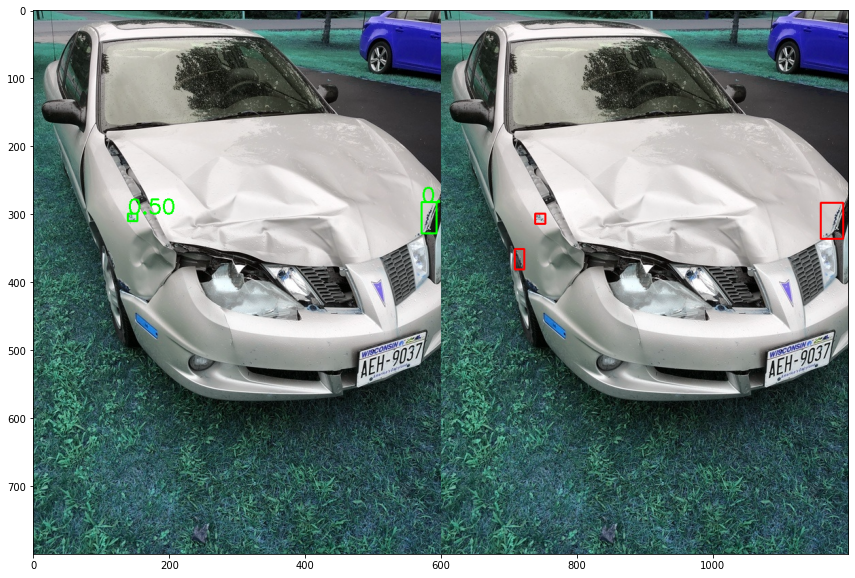

In [6]:
plot('2596', pred_data, img_to_anns)

## Plot FP, TP boxes

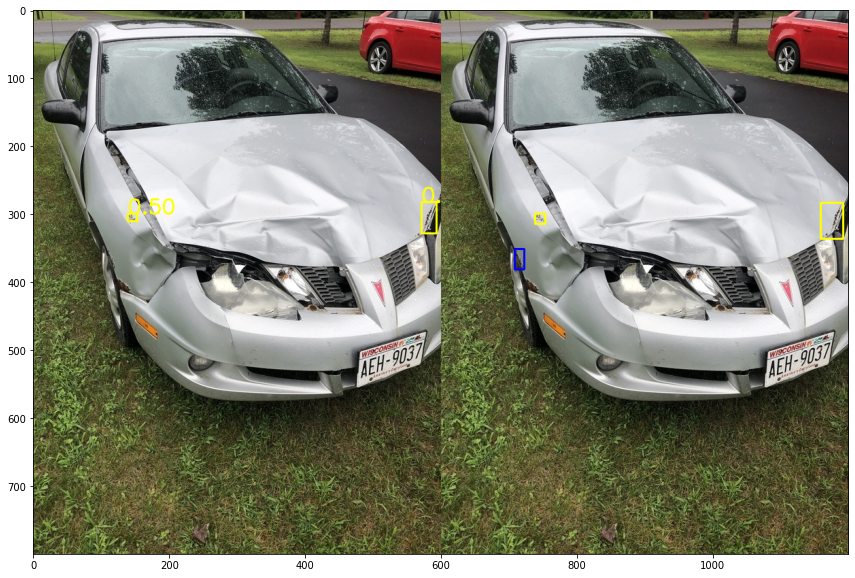

In [8]:
plot_fp('2596', pred_data, img_to_anns)

In [19]:
def evaluate_model(config_file, checkpoint, pred_output_name, version_name):
    model = init_detector(config_file, checkpoint, device='cuda:1')
    test_data = json.load(open('/mmdetection/data/scratch/annotations/clean_test.json'))
    get_pred_data(model=model,out_put_name = pred_output_name, test_data=test_data)
    pred_output_name = pred_output_name + '.json'
    pred_data = json.load(open(os.path.join('./output_data/',pred_output_name)))
    metrics = [version_name] + list(compute_mean_eval_metrics(img_to_anns, pred_data)) + [sum(len(val['bboxes']) for img,val in pred_data.items())]
    append_metrics_to_csv(metrics, './output_data/eval_metrics.csv')    

In [13]:
config_file = '/mmdetection/checkpoints/scratch/demo_scratch_v8/scratch.py'
checkpoint = '/mmdetection/checkpoints/scratch/demo_scratch_v8/latest.pth'
test_data = json.load(open('/mmdetection/data/scratch/annotations/clean_test.json'))
imgs_path = '/mmdetection/data/scratch/images/'

img_to_anns = defaultdict(list)
for ann in test_data['annotations']:
    img_to_anns[ann['image_id']].append(ann)

version_name = 'v8_22_6'
pred_output_name = 'scratch_predicted_result_v8'
evaluate_model(config_file, checkpoint, pred_output_name, version_name)
eval_metrics_table = pd.read_csv('./output_data/eval_metrics.csv')
eval_metrics_table

load checkpoint from local path: /mmdetection/checkpoints/scratch/demo_scratch_v8/latest.pth


  1%|█▌                                                                                                                                                                                                                       | 27/3724 [00:06<15:00,  4.11it/s]


KeyboardInterrupt: 

In [20]:
test_data = json.load(open('/mmdetection/data/scratch/annotations/clean_test.json'))
imgs_path = '/mmdetection/data/scratch/images/'

img_to_anns = defaultdict(list)
for ann in test_data['annotations']:
    img_to_anns[ann['image_id']].append(ann)

pred_data = json.load(open(os.path.join('./output_data/','scratch_predicted_result_v8.json')))
metrics = ['v8_22_6'] + list(compute_mean_eval_metrics(img_to_anns, pred_data)) + [sum(len(val['bboxes']) for img,val in pred_data.items())]
append_metrics_to_csv(metrics, './output_data/eval_metrics.csv') 

In [ ]:
config_file = '/mmdetection/checkpoints/scratch/demo_scratch_v9/scratch_ohem.py'
checkpoint = '/mmdetection/checkpoints/scratch/demo_scratch_v9/latest.pth'
test_data = json.load(open('/mmdetection/data/scratch/annotations/clean_test.json'))
imgs_path = '/mmdetection/data/scratch/images/'

img_to_anns = defaultdict(list)
for ann in test_data['annotations']:
    img_to_anns[ann['image_id']].append(ann)

version_name = 'v9_25_6'
pred_output_name = 'scratch_predicted_result_v9'
evaluate_model(config_file, checkpoint, pred_output_name, version_name)

In [26]:
eval_metrics_table = pd.read_csv('./output_data/eval_metrics.csv')
eval_metrics_table


,model,TP,FP,FN,Precision mean,Recall mean,F1_score mean,no_scratches
0,v1_7_6,8328,8932,10030,0.463668,0.493627,0.427373,18455
1,v2_13_6,8248,9133,10110,0.451929,0.490042,0.420533,18553
2,v3_15_6,8325,9111,10033,0.458840,0.494714,0.425824,18582
3,v4_16_6,4275,8142,14083,0.288647,0.283950,0.249056,14899
4,v8_22_6,8249,8767,10109,0.464018,0.489716,0.426548,18238
5,v9_25_6,6816,4952,11542,0.500513,0.414487,0.408008,12278
6,v8_22_6,8249,8767,10109,0.464018,0.489716,0.426548,18238
7,v12_30_6,8325,8833,10033,0.461009,0.498070,0.429387,18424
8,v13_01_7,8427,8898,9931,0.462031,0.499227,0.429897,18428


In [23]:
config_file = '/mmdetection/checkpoints/scratch/demo_scratch_v12/scratch_v12.py'
checkpoint = '/mmdetection/checkpoints/scratch/demo_scratch_v12/epoch_30.pth'
test_data = json.load(open('/mmdetection/data/scratch/annotations/clean_test.json'))
imgs_path = '/mmdetection/data/scratch/images/'

img_to_anns = defaultdict(list)
for ann in test_data['annotations']:
    img_to_anns[ann['image_id']].append(ann)

version_name = 'v12_30_6'
pred_output_name = 'scratch_predicted_result_v12'
evaluate_model(config_file, checkpoint, pred_output_name, version_name)

/mmdetection/mmdet/core/anchor/builder.py:16: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  '``build_anchor_generator`` would be deprecated soon, please use '


load checkpoint from local path: /mmdetection/checkpoints/scratch/demo_scratch_v12/epoch_30.pth


  0%|                                                                                                                                                                                                                                  | 0/3724 [00:00<?, ?it/s]/mmdetection/mmdet/datasets/utils.py:68: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  'data pipeline in your config file.', UserWarning)
/mmdetection/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/mmdetection/mmdet/core/anchor/anchor_generator.py:360: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  '``single_level_grid_anchors`` would be deprecated soon. '
100%|████████████████████████████████

In [25]:
config_file = '/mmdetection/checkpoints/scratch/demo_scratch_v13/scratch.py'
checkpoint = '/mmdetection/checkpoints/scratch/demo_scratch_v13/epoch_29.pth'
test_data = json.load(open('/mmdetection/data/scratch/annotations/clean_test.json'))
imgs_path = '/mmdetection/data/scratch/images/'

img_to_anns = defaultdict(list)
for ann in test_data['annotations']:
    img_to_anns[ann['image_id']].append(ann)

version_name = 'v13_01_7'
pred_output_name = 'scratch_predicted_result_v13'
evaluate_model(config_file, checkpoint, pred_output_name, version_name)

load checkpoint from local path: /mmdetection/checkpoints/scratch/demo_scratch_v13/epoch_29.pth


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3724/3724 [16:32<00:00,  3.75it/s]
